In [1]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/chaklam/bci_project/BCI/P300/utils')

import pandas as pd
import numpy as np

import mne
from mne.time_frequency import psd_welch

import helper as helper #custom

# visualization stuff
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# 1. Import Data

In [26]:
df = pd.read_csv('data/p300-6trials-12rep-chaky.csv')

In [3]:
df.shape #check the size of 0

(53328, 10)

In [4]:
print(df[df.Marker==2].shape) #10hz
print(df[df.Marker==1].shape) #6hz

(72, 10)
(648, 10)


In [5]:
df.rename(columns={'Unnamed: 1':'P4',
                          'Unnamed: 2':'Pz',
                          'Unnamed: 3':'P3',
                           'Unnamed: 4':'PO4',
                          'Unnamed: 5':'POz',
                           'Unnamed: 6':'PO3',
                          'Unnamed: 7':'O2',
                           'Unnamed: 8': 'O1'
                           
                      }, 
                 inplace=True)

In [6]:
df.head()

,timestamps,P4,Pz,P3,PO4,POz,PO3,O2,O1,Marker
0,55102.712,43787.426,36719.758,19511.619,47260.172,38144.504,36332.605,24059.730,19694.703,0
1,55102.712,43780.832,36711.020,19499.572,47253.020,38134.625,36320.555,24050.947,19682.455,0
2,55102.713,43788.094,36718.016,19503.305,47263.008,38141.910,36326.344,24061.363,19692.646,0
3,55102.713,43778.371,36705.117,19489.291,47253.285,38129.258,36311.707,24055.416,19674.988,0
4,55102.714,43778.484,36702.750,19484.619,47249.172,38125.461,36304.148,24050.566,19666.764,0


In [7]:
df = df.drop(["timestamps"], axis=1)

In [8]:
df.head()

,P4,Pz,P3,PO4,POz,PO3,O2,O1,Marker
0,43787.426,36719.758,19511.619,47260.172,38144.504,36332.605,24059.730,19694.703,0
1,43780.832,36711.020,19499.572,47253.020,38134.625,36320.555,24050.947,19682.455,0
2,43788.094,36718.016,19503.305,47263.008,38141.910,36326.344,24061.363,19692.646,0
3,43778.371,36705.117,19489.291,47253.285,38129.258,36311.707,24055.416,19674.988,0
4,43778.484,36702.750,19484.619,47249.172,38125.461,36304.148,24050.566,19666.764,0


# 2. Transform Data into Raw MNE object

Creating RawArray with float64 data, n_channels=9, n_times=53328
    Range : 0 ... 53327 =      0.000 ...   213.308 secs
Ready.
Effective window size : 8.192 (s)


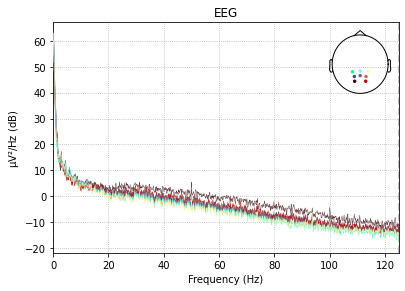

In [9]:
raw = helper.df_to_raw(df)

# 3. Preprocessing

## Notch Filter

Some artifacts are restricted to certain frequencies and can therefore be fixed by filtering. An artifact that typically affects only some frequencies is due to the power line.

Power-line noise is a noise created by the electrical network. It is composed of sharp peaks at 50Hz (or 60Hz depending on your geographical location). Some peaks may also be present at the harmonic frequencies, i.e. the integer multiples of the power-line frequency, e.g. 100Hz, 150Hz, … (or 120Hz, 180Hz, …).

Remove the 50Hz power line noise in Thailand.  We will also be remove its harmonics, i.e., 100Hz, 150Hz, etc.  Since our signal is 125Hz (250Hz / 2 according to Nyquist Theorem), we shall run the harmonics until 125 Hz.

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Effective window size : 8.192 (s)


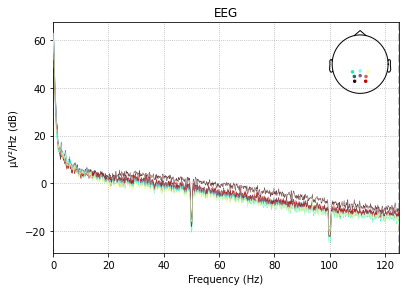

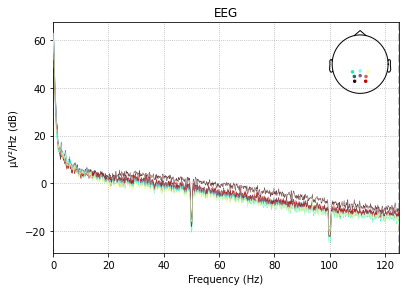

In [10]:
raw.notch_filter(np.arange(50, 125, 50), filter_length='auto', phase='zero') #250/2 based on Nyquist Theorem
#observe that the 50Hz noise is now gone, yay!
raw.plot_psd()

## Band pass filter

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Effective window size : 8.192 (s)


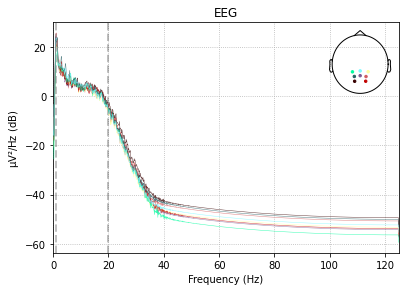

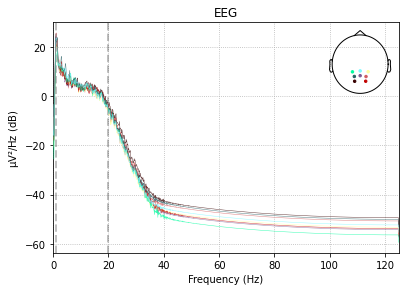

In [11]:
#according to https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0077536,
#the optimal range is 12-18hz

#since we use 6hz, 10hz, and 15hz, 
#we will take five harmonics, which maximum freq is 15 x 5 = 75
#we will take +- 2 at each end, thus 6-2 = 4, and 75+2 = 77

raw.filter(1, 20, method='iir')

raw.plot_psd()

# 3. Epoching

In [12]:
#this one requires expertise to specify the right tmin, tmax
event_id = {'Non-Target': 1, 'Target' : 2}
tmin = -0.1
tmax = 0.6
picks=[0, 1, 2, 3, 4, 5, 6, 7]
epochs = helper.getEpochs(raw, event_id, tmin, tmax, picks)
#print(epochs.get_data())

720 events found
Event IDs: [1 2]
sample drop %:  0.0


## Plotting ERP of targets vs. non-targets

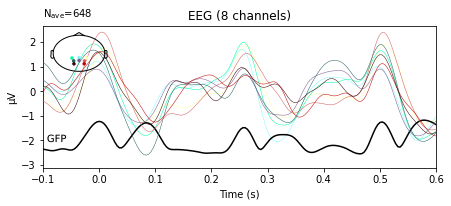

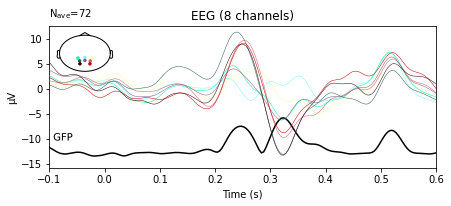

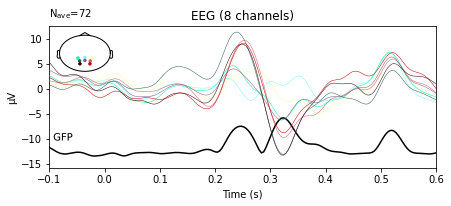

In [13]:
evoked_non = epochs['Non-Target'].average()
evoked_non.plot(spatial_colors=True, gfp=True, time_unit='s')
evoked_target = epochs['Target'].average()
evoked_target.plot(spatial_colors=True, gfp=True, time_unit='s')

## Plotting scalp topographies

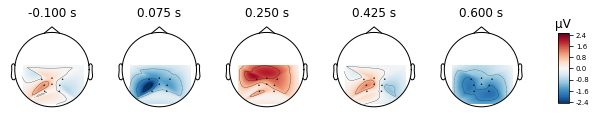

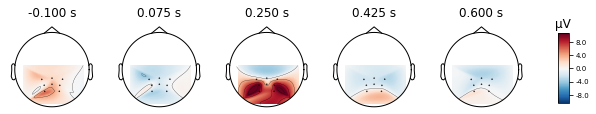

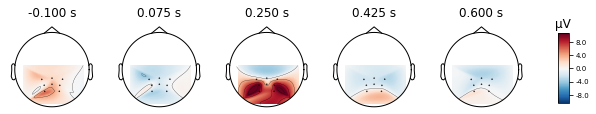

In [14]:
times = np.linspace(-0.1, 0.6, 5)
evoked_non.plot_topomap(ch_type='eeg', times=times, colorbar=True)
evoked_target.plot_topomap(ch_type='eeg', times=times, colorbar=True)

## Plotting ERP together with topographies

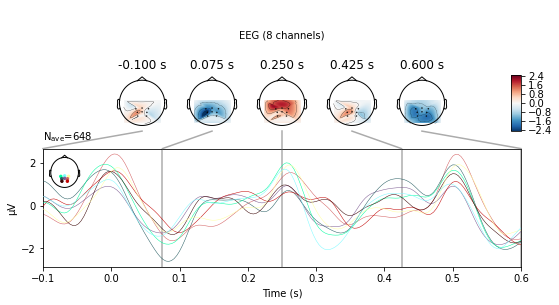

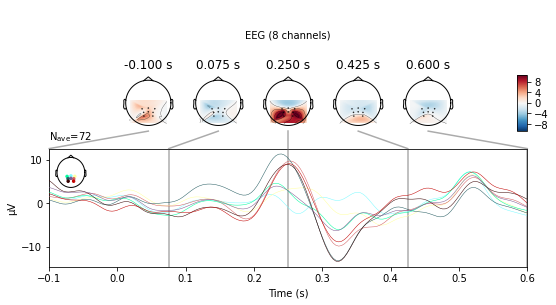

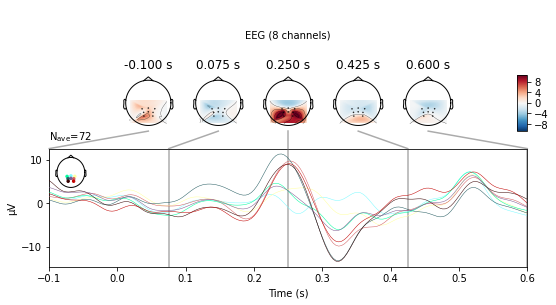

In [15]:
evoked_non.plot_joint(times=times)
evoked_target.plot_joint(times=times)

## Image Plots

648 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


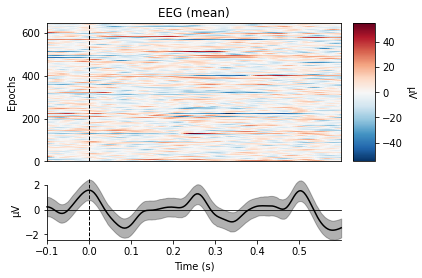

72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


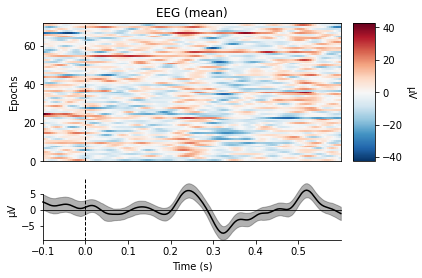

[<Figure size 432x288 with 3 Axes>]

In [16]:
epochs['Non-Target'].plot_image(picks='eeg', combine='mean')
epochs['Target'].plot_image(picks='eeg', combine='mean')

## Comparing Evoked objects

More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


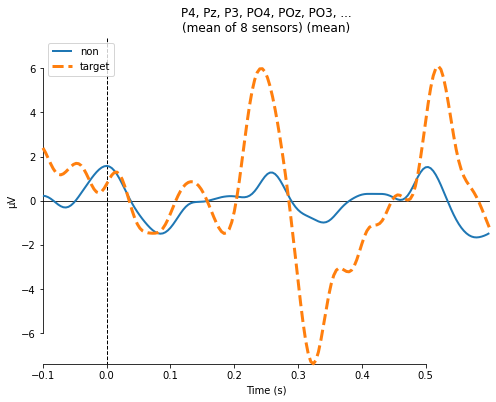

More than 6 channels, truncating title ...
combining channels using "median"
combining channels using "median"


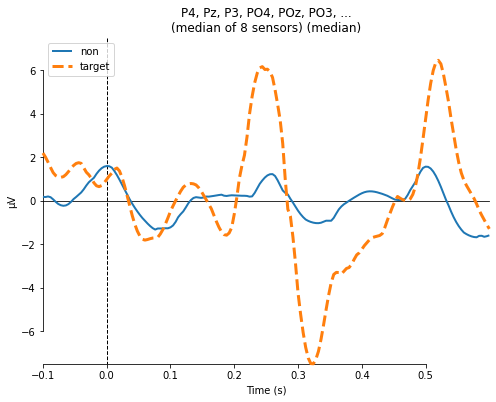

combining channels using "gfp"
combining channels using "gfp"


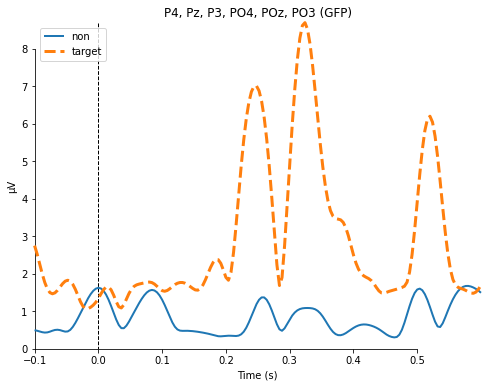

More than 6 channels, truncating title ...
combining channels using "<function custom_func at 0x7efc2724df28>"
combining channels using "<function custom_func at 0x7efc2724df28>"


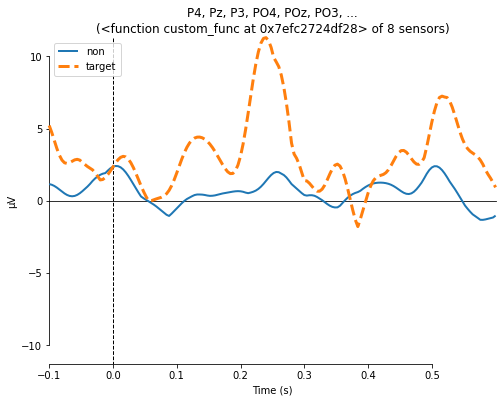

In [18]:
def custom_func(x):
    return x.max(axis=1)

total_evoked = {"non": evoked_non, "target": evoked_target}
for combine in ('mean', 'median', 'gfp', custom_func):
    mne.viz.plot_compare_evokeds(total_evoked, picks=[0,1,2,3,4,5,6,7], combine=combine,
                                colors=dict(non=0, target=1),
                                linestyles=dict(non='solid', target='dashed'),
                                 styles=dict(non=dict(linewidth=2),target=dict(linewidth=3))) 

## Topographical subplots

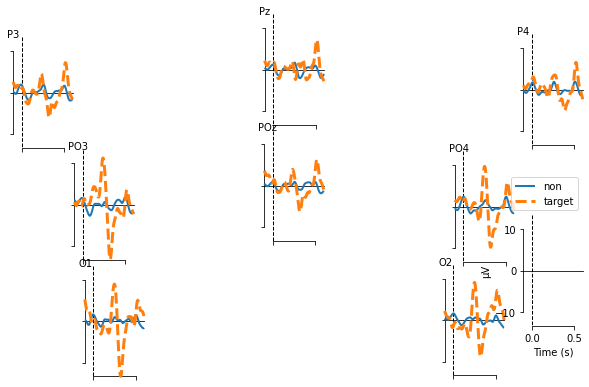

[<Figure size 1296x1008 with 9 Axes>]

In [20]:
mne.viz.plot_compare_evokeds(total_evoked, picks='eeg',
                                colors=dict(non=0, target=1), axes='topo',
                                linestyles=dict(non='solid', target='dashed'),
                            styles=dict(non=dict(linewidth=2),target=dict(linewidth=3)))

#somehow the scaler on the bottom right cannot be removed.  Not sure
#it has to do with anything with plot_compare_evokeds
#tried legend=False to no avail
#also, it looks ugly af!

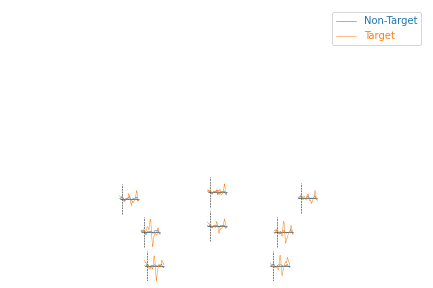

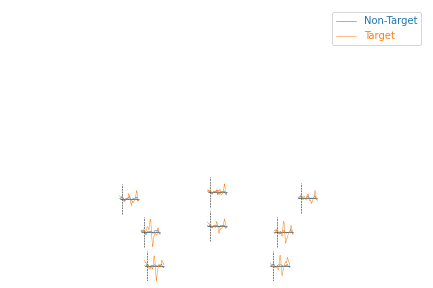

In [21]:
evokeds = [epochs[name].average() for name in ('Non-Target', 'Target')]
mne.viz.plot_evoked_topo(evokeds, layout_scale=1)

# Decoding ERP

In [22]:
tmin = 0.2
tmax = 0.5
picks=[0, 1, 2, 3, 4, 5, 6, 7]  #selected channels
epochs = helper.getEpochs(raw, event_id, tmin, tmax, picks)
X = epochs.get_data()
y = epochs.events[:, -1]

720 events found
Event IDs: [1 2]
sample drop %:  0.0


/home/chaklam/bci_project/bci_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/chaklam/bci_project/bci_env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


ERP + TS
              precision    recall  f1-score   support

  Non-target       0.98      0.99      0.99       648
     targets       0.91      0.83      0.87        72

    accuracy                           0.97       720
   macro avg       0.95      0.91      0.93       720
weighted avg       0.97      0.97      0.97       720

ERP + MDM
              precision    recall  f1-score   support

  Non-target       0.99      0.92      0.95       648
     targets       0.55      0.94      0.70        72

    accuracy                           0.92       720
   macro avg       0.77      0.93      0.83       720
weighted avg       0.95      0.92      0.93       720

Xdawn + RegLDA
              precision    recall  f1-score   support

  Non-target       0.98      0.98      0.98       648
     targets       0.80      0.82      0.81        72

    accuracy                           0.96       720
   macro avg       0.89      0.90      0.89       720
weighted avg       0.96      0.96      0

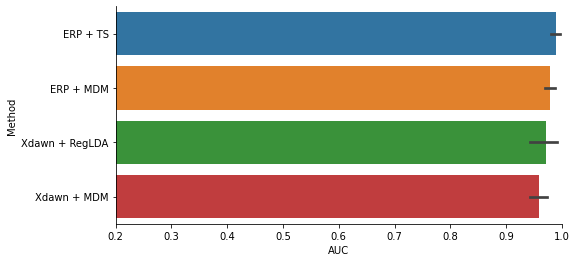

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from mne.preprocessing import Xdawn
from pyriemann.estimation import ERPCovariances
from collections import OrderedDict
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.estimation import XdawnCovariances

from sklearn.metrics import classification_report


from mne.decoding import Vectorizer
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline

lda = LDA(shrinkage='auto', solver='eigen') #Regularized LDA
lr = LogisticRegression(penalty='l1', solver='liblinear',
                                       multi_class='auto')

clfs = OrderedDict()

n_components = 3

clfs['ERP + TS']= make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['ERP + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clfs['Xdawn + RegLDA'] = make_pipeline(XdawnCovariances(n_components, 
                            estimator='oas'), Vectorizer(), lda)
clfs['Xdawn + MDM'] = make_pipeline(XdawnCovariances(n_components,
                            estimator='oas'), MDM())

# Cross validator
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

for clf in clfs:
    # Do cross-validation
    preds = np.empty(len(y))
    for train, test in cv.split(X, y):  #Xdawn takes in epoch object
        clfs[clf].fit(X[train], y[train])
        preds[test] = clfs[clf].predict(X[test])

    # Classification report
    target_names = ['Non-target', 'targets']
    report = classification_report(y, preds, target_names=target_names)
    print(clf)
    print(report)
    
# measure auc
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 1)
sns.despine()

In [24]:
## For inspecting

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7,
                                                   random_state=42)

model = clfs['Xdawn + RegLDA'].fit(X_train, y_train)
preds = model.predict(X_test)
report = classification_report(y_test, preds, target_names=target_names)
print(report)
print(preds)
print(y_test)

              precision    recall  f1-score   support

  Non-target       0.98      0.98      0.98       460
     targets       0.78      0.80      0.79        44

    accuracy                           0.96       504
   macro avg       0.88      0.89      0.88       504
weighted avg       0.96      0.96      0.96       504

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 2 1 1
 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 1 1 1 2 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1
 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 